In [1]:
# import warnings
# warnings.filterwarnings("ignore")

In [2]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import transforms
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from torch.optim import SGD
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from engine import train_one_epoch, evaluate

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
import json
import PIL.Image
from matplotlib import pyplot as plt
#train the models on the big dataset with all classes and single faces
import numpy as np
import os
import torch
import time




In [3]:
from face_mask_datasets import MaskDetectionDatasetJSON, MaskDetectionDatasetXML

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

CLASS_LABELS_ALL = {
    "empty": 0,
    "mask_colorful": 1,
    "mask_surgical": 2,
    "face_no_mask": 3,
    "face_with_mask_incorrect": 4,
    "face_with_mask": 5,
    "face_other_covering": 6,
    "scarf_bandana": 7,
    "balaclava_ski_mask": 8,
    "face_shield": 9,
    "other": 10,
    "gas_mask": 11,
    "turban": 12,
    "helmet": 13,
    "sunglasses": 14,
    "eyeglasses": 15,
    "hair_net": 16,
    "hat": 17,
    "goggles": 18,
    "hood": 19,
    "hijab_niqab": 20,
}

CLASS_LABELS_FACES = {
    "empty": 0,
    "face_no_mask": 1,
    "face_with_mask_incorrect": 2,
    "face_with_mask": 3,
    "face_other_covering": 4
}

CLASS_LABELS_XML = {
    "empy": 0,
    "without_mask": 1,
    "with_mask": 2,
    "mask_weared_incorrect": 3,
}

TRAIN_PRECENTAGE = 0.8  # 80% of the data is used for training
BATCH_SIZE = 12
NUM_EPOCHS = 10
LEARNING_RATE = 0.005
print("Using device: ", device)

Using device:  cuda


In [ ]:
#start a timer
start_time = time.time()

In [4]:
# dataset_big = MaskDetectionDatasetJSON("C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\Medical Mask",CLASS_LABELS, (512,512))
# dataset_big_singleFaces = MaskDetectionDatasetJSON("C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\Medical Mask",CLASS_LABELS,(512,512), only_single_faces=True)
# dataset_big_multipleFaces = MaskDetectionDatasetJSON("C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\Medical Mask",CLASS_LABELS,(512,512), only_multiple_faces=True)

# dataset_small = MaskDetectionDatasetXML("C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Kaggle Face Mask Detection Full",(512,512))
# dataset_small_low_light = MaskDetectionDatasetXML("C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Kaggle Face Mask Detection Full",(512,512), use_dark_images=True)

# #create a dict of the datasets

# datasets = {
#     "dataset_big": dataset_big,
#     "dataset_big_singleFaces": dataset_big_singleFaces,
#     "dataset_big_multipleFaces": dataset_big_multipleFaces,
#     "dataset_small": dataset_small,
#     "dataset_small_low_light": dataset_small_low_light
#}

In [5]:
dataset_big_all_classes = MaskDetectionDatasetJSON("C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\Medical Mask",CLASS_LABELS_ALL, (512,512))
dataset_big_face_classes = MaskDetectionDatasetJSON("C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\Medical Mask",CLASS_LABELS_FACES,(512,512))

#create a dict of the datasets

datasets = {
    "dataset_big_all_classes": dataset_big_all_classes,
    "dataset_big_face_classes": dataset_big_face_classes
}

dataset init
dataset init


c:\GIT_Workspaces\Deep-Vision-sta\Faster R-CNN\face_mask_datasets.py:62: UserWarning: File 1855.jpg has no annotations
  warnings.warn(f"File {file_name} has no annotations")
c:\GIT_Workspaces\Deep-Vision-sta\Faster R-CNN\face_mask_datasets.py:62: UserWarning: File 1945.jpg has no annotations
  warnings.warn(f"File {file_name} has no annotations")
c:\GIT_Workspaces\Deep-Vision-sta\Faster R-CNN\face_mask_datasets.py:62: UserWarning: File 2135.jpg has no annotations
  warnings.warn(f"File {file_name} has no annotations")
c:\GIT_Workspaces\Deep-Vision-sta\Faster R-CNN\face_mask_datasets.py:62: UserWarning: File 3102.png has no annotations
  warnings.warn(f"File {file_name} has no annotations")
c:\GIT_Workspaces\Deep-Vision-sta\Faster R-CNN\face_mask_datasets.py:62: UserWarning: File 4618.png has no annotations
  warnings.warn(f"File {file_name} has no annotations")
c:\GIT_Workspaces\Deep-Vision-sta\Faster R-CNN\face_mask_datasets.py:62: UserWarning: File 5012.jpg has no annotations
  warn

In [6]:
dataset_big_face_classes.annotations[52]

([{'isProtected': False,
   'ID': 537667945160657984,
   'BoundingBox': [680, 340, 1664, 1784],
   'classname': 'face_no_mask',
   'Confidence': 1,
   'Attributes': {}}],
 '1856.jpg')

In [7]:
dataset_big_all_classes.annotations[52]

([{'isProtected': False,
   'ID': 702780802691515392,
   'BoundingBox': [480, 143, 586, 230],
   'classname': 'mask_surgical',
   'Confidence': 1,
   'Attributes': {}}],
 '1855.jpg')

In [8]:
dataset_big_face_classes.__len__()

4314

In [9]:
#create dataloaders for datasets

import torch
from torch.utils.data import Dataset, DataLoader
import utils

dataloaders = {}

for dataset_name, dataset in datasets.items():
    train_size = int(TRAIN_PRECENTAGE * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=utils.collate_fn)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=utils.collate_fn)
    dataloaders[dataset_name] = {
        "train": train_dataloader,
        "test": test_dataloader
    }

In [10]:
def getNewModelsClassCompare():
    model_resnet_all_classes = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    model_resnet_face_classes = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    model_mobile_all_classes = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
    model_mobile_face_classes = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)

    models_classComparison = {
        "resnet":{
            "all_classes": model_resnet_all_classes,
            "face_classes": model_resnet_face_classes
        },
        "mobile":{
            "all_classes": model_mobile_all_classes,
            "face_classes": model_mobile_face_classes
        }
    }
    return models_classComparison

In [11]:
models_classComparison = getNewModelsClassCompare()

num_classes = {
    "all_classes": 21,
    "face_classes": 5
}

#prepare models

for model_name, model_dict in models_classComparison.items():
    for model_type, model in model_dict.items():
        # get number of input features for the classifier
        in_features = model.roi_heads.box_predictor.cls_score.in_features

        # number of classes
        nc = num_classes[model_type]

        # replace the pre-trained head with a new one
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, nc)

        # move model to the right device
        model.to(device)

c:\Users\johan\.conda\envs\DV-STA\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\johan\.conda\envs\DV-STA\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\johan\.conda\envs\DV-STA\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You 

In [12]:
classnames = set()

for item in dataset_big_face_classes.annotations:
    objects, _ = item
    for obj in objects:
        classnames.add(obj['classname'])

unique_classnames = list(classnames)
print(unique_classnames)

['face_no_mask', 'face_with_mask_incorrect', 'face_with_mask', 'face_other_covering']


In [13]:
import copy
from engine import train_one_epoch, evaluate

def train_model(model, dataloaders, optimizer, num_epochs=10):

    # Define empty arrays to collect metrics
    ap_values = []
    ar_values = []

    losses = []
    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, dataloaders["train"], device, epoch, print_freq=1, losses_out=losses)
        # evaluate on the test dataset
        evaluator = evaluate(model, dataloaders["test"], device)

        # Extract the metrics from the evaluator
        average_precisions = evaluator.coco_eval['bbox'].stats[:6]
        average_recalls = evaluator.coco_eval['bbox'].stats[6:]

        # Append the metrics to the arrays
        ap_values.append(average_precisions)
        ar_values.append(average_recalls)

    return model, ap_values, ar_values, losses

In [14]:
%matplotlib inline
models_trained = {}

model_type__dataloader_map = {
    "all_classes": "dataset_big_all_classes",
    "face_classes": "dataset_big_face_classes"
}


for model_name, model_dict in models_classComparison.items():
    models_trained[model_name] = {}
    for model_type, model in model_dict.items():

        # if(model_type == "all_classes"):
        #     continue
        
        print("Training model: ", model_name, " ", model_type)
        print("using dataset: ", model_type__dataloader_map[model_type])
        print("--------------------------------------------------")
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0005)
        model, ap_values, ar_values, losses = train_model(model, dataloaders[model_type__dataloader_map[model_type]], optimizer, num_epochs=NUM_EPOCHS)
        models_trained[model_name][model_type] = model

        # Save the model into the "finished_models" folder
        model_filename = f"{model_name}_{model_type}.pth"
        model_path = os.path.join("finished_models/class_compare/", model_filename)
        torch.save(model.state_dict(), model_path)

        # Save the metrics into the "metric_history" folder
        metric_filename = f"{model_name}_{model_type}_metrics.npz"
        metric_path = os.path.join("finished_models/class_compare/metric_history", metric_filename)
        np.savez(metric_path, ap_values=ap_values, ar_values=ar_values, losses=losses)

        #free memory for next model
        torch.cuda.empty_cache()

        #wait 3 seconds
        print("continue with next model in 3 seconds")
        time.sleep(3)


Training model:  resnet   all_classes
using dataset:  dataset_big_all_classes
--------------------------------------------------
Epoch: [0]  [  0/289]  eta: 0:16:33  lr: 0.000022  loss: 3.1853 (3.1853)  loss_classifier: 2.8699 (2.8699)  loss_box_reg: 0.1929 (0.1929)  loss_objectness: 0.1072 (0.1072)  loss_rpn_box_reg: 0.0153 (0.0153)  time: 3.4368  data: 0.1382  max mem: 8869
Epoch: [0]  [  1/289]  eta: 0:10:25  lr: 0.000040  loss: 3.1853 (3.2468)  loss_classifier: 2.8699 (2.8748)  loss_box_reg: 0.1929 (0.2126)  loss_objectness: 0.1072 (0.1397)  loss_rpn_box_reg: 0.0153 (0.0198)  time: 2.1732  data: 0.1731  max mem: 9027
Epoch: [0]  [  2/289]  eta: 0:08:21  lr: 0.000057  loss: 3.3084 (3.2937)  loss_classifier: 2.8797 (2.8810)  loss_box_reg: 0.2255 (0.2169)  loss_objectness: 0.1721 (0.1712)  loss_rpn_box_reg: 0.0243 (0.0246)  time: 1.7465  data: 0.1787  max mem: 9027
Epoch: [0]  [  3/289]  eta: 0:07:16  lr: 0.000074  loss: 3.2315 (3.2781)  loss_classifier: 2.8699 (2.8626)  loss_box_reg:

In [14]:
def getNewModelsLightCompare():
    model_resnet_light = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    model_resnet_dark = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    model_mobile_light = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
    model_mobile_dark = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)

    models_lightCompare = {
        "resnet":{
            "light": model_resnet_light,
            "dark": model_resnet_dark
        },
        "mobile":{
            "light": model_mobile_light,
            "dark": model_mobile_dark
        }
    }
    return models_lightCompare

In [15]:
models_lightCompare = getNewModelsLightCompare()

for model_name, model_dict in models_lightCompare.items():
    for model_type, model in model_dict.items():
        # get number of input features for the classifier
        in_features = model.roi_heads.box_predictor.cls_score.in_features

        # number of classes
        nc = 4

        # replace the pre-trained head with a new one
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, nc)

        # move model to the right device
        model.to(device)

dataset_xml_dark = MaskDetectionDatasetXML("C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Kaggle Face Mask Detection Full",CLASS_LABELS_XML,(512,512), use_dark_images=True)
dataset_xml_light = MaskDetectionDatasetXML("C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Kaggle Face Mask Detection Full",CLASS_LABELS_XML,(512,512), use_dark_images=False)

datasets_light = {
    "dataset_xml_dark": dataset_xml_dark,
    "dataset_xml_light": dataset_xml_light
}

dataloaders_light = {}

for dataset_name, dataset in datasets_light.items():
    train_size = int(TRAIN_PRECENTAGE * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=utils.collate_fn)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=utils.collate_fn)
    dataloaders_light[dataset_name] = {
        "train": train_dataloader,
        "test": test_dataloader
    }

In [16]:
dataloaders_light

{'dataset_xml_dark': {'train': <torch.utils.data.dataloader.DataLoader at 0x1d7a2d7e550>,
  'test': <torch.utils.data.dataloader.DataLoader at 0x1d7a2d7e700>},
 'dataset_xml_light': {'train': <torch.utils.data.dataloader.DataLoader at 0x1d7a2d7e8b0>,
  'test': <torch.utils.data.dataloader.DataLoader at 0x1d7a2d7eb80>}}

In [18]:
models_light_trained = {}

model_type__dataloader_map = {
    "light": "dataset_xml_light",
    "dark": "dataset_xml_dark"
}

for model_name, model_dict in models_lightCompare.items():
    models_light_trained[model_name] = {}
    for model_type, model in model_dict.items():
        
        print("Training model: ", model_name, " ", model_type)
        print("using dataset: ", model_type__dataloader_map[model_type])
        print("--------------------------------------------------")
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0005)
        model, ap_values, ar_values, losses = train_model(model, dataloaders_light[model_type__dataloader_map[model_type]], optimizer, num_epochs=NUM_EPOCHS)
        models_light_trained[model_name][model_type] = model

        # Save the model into the "finished_models" folder
        model_filename = f"{model_name}_{model_type}.pth"
        model_path = os.path.join("finished_models/light_compare/", model_filename)
        torch.save(model.state_dict(), model_path)

        # Save the metrics into the "metric_history" folder
        metric_filename = f"{model_name}_{model_type}_metrics.npz"
        metric_path = os.path.join("finished_models/light_compare/metric_history", metric_filename)
        np.savez(metric_path, ap_values=ap_values, ar_values=ar_values, losses=losses)

        #free memory for next model
        torch.cuda.empty_cache()

        #wait 3 seconds
        print("continue with next model in 3 seconds")
        time.sleep(3)

Training model:  resnet   light
using dataset:  dataset_xml_light
--------------------------------------------------
Epoch: [0]  [ 0/57]  eta: 0:00:50  lr: 0.000094  loss: 1.5957 (1.5957)  loss_classifier: 1.2418 (1.2418)  loss_box_reg: 0.1182 (0.1182)  loss_objectness: 0.1835 (0.1835)  loss_rpn_box_reg: 0.0522 (0.0522)  time: 0.8847  data: 0.1330  max mem: 9811
Epoch: [0]  [ 1/57]  eta: 0:00:48  lr: 0.000183  loss: 1.5957 (1.6916)  loss_classifier: 1.2418 (1.2623)  loss_box_reg: 0.1182 (0.1297)  loss_objectness: 0.1835 (0.2153)  loss_rpn_box_reg: 0.0522 (0.0842)  time: 0.8616  data: 0.1350  max mem: 9969
Epoch: [0]  [ 2/57]  eta: 0:00:46  lr: 0.000273  loss: 1.5957 (1.6339)  loss_classifier: 1.2810 (1.2685)  loss_box_reg: 0.1395 (0.1329)  loss_objectness: 0.1835 (0.1706)  loss_rpn_box_reg: 0.0522 (0.0618)  time: 0.8495  data: 0.1320  max mem: 9969
Epoch: [0]  [ 3/57]  eta: 0:00:45  lr: 0.000362  loss: 1.5185 (1.5871)  loss_classifier: 1.2418 (1.2454)  loss_box_reg: 0.1332 (0.1330)  lo

In [17]:
model_single_face_resnet = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_single_face_mobile = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)

#prepare models

for model in [model_single_face_resnet, model_single_face_mobile]:
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # number of classes
    nc = 5

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, nc)

    # move model to the right device
    model.to(device)

dataset_single_face = MaskDetectionDatasetJSON("C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\Medical Mask",CLASS_LABELS_FACES,(512,512), only_single_faces=True)
dataset_multiple_face = MaskDetectionDatasetJSON("C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\Medical Mask",CLASS_LABELS_FACES,(512,512), only_multiple_faces=True)

datasets_single_face = {
    "dataset_single_face": dataset_single_face,
    "dataset_multiple_face": dataset_multiple_face
}

dataloaders_crowds = {}

for dataset_name, dataset in datasets_single_face.items():
    train_size = int(TRAIN_PRECENTAGE * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=utils.collate_fn)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=utils.collate_fn)
    dataloaders_crowds[dataset_name] = {
        "train": train_dataloader,
        "test": test_dataloader
    }

dataset init
dataset init


In [18]:
single = dataset_single_face.__len__()
multi = dataset_multiple_face.__len__()

print("lenght of single face dataset: ", single, " lenght of multiple face dataset: ", multi)

lenght of single face dataset:  2958  lenght of multiple face dataset:  1356


In [19]:
#train models on single dataset only

models_single_face_trained = {}

for model_name, model in zip(["resnet", "mobile"], [model_single_face_resnet, model_single_face_mobile]):
    models_single_face_trained[model_name] = {}
    for dataset_name, dataloader in dataloaders_crowds.items():
        print("Training model: ", model_name, " ", dataset_name)
        print("--------------------------------------------------")
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0005)
        model, ap_values, ar_values, losses = train_model(model, dataloader, optimizer, num_epochs=NUM_EPOCHS)
        models_single_face_trained[model_name][dataset_name] = model

        # Save the model into the "finished_models" folder
        model_filename = f"{model_name}_{dataset_name}.pth"
        model_path = os.path.join("finished_models/single_face/", model_filename)
        torch.save(model.state_dict(), model_path)

        # Save the metrics into the "metric_history" folder
        metric_filename = f"{model_name}_{dataset_name}_metrics.npz"
        metric_path = os.path.join("finished_models/single_face/metric_history", metric_filename)
        np.savez(metric_path, ap_values=ap_values, ar_values=ar_values, losses=losses)

        #free memory for next model
        torch.cuda.empty_cache()

        #wait 3 seconds
        print("continue with next model in 3 seconds")
        time.sleep(3)

Training model:  resnet   dataset_single_face
--------------------------------------------------
Epoch: [0]  [  0/198]  eta: 0:12:35  lr: 0.000030  loss: 1.8334 (1.8334)  loss_classifier: 1.7122 (1.7122)  loss_box_reg: 0.0926 (0.0926)  loss_objectness: 0.0235 (0.0235)  loss_rpn_box_reg: 0.0052 (0.0052)  time: 3.8138  data: 0.1380  max mem: 9573
Epoch: [0]  [  1/198]  eta: 0:07:39  lr: 0.000056  loss: 1.8334 (1.8651)  loss_classifier: 1.7122 (1.7279)  loss_box_reg: 0.0926 (0.1085)  loss_objectness: 0.0229 (0.0232)  loss_rpn_box_reg: 0.0052 (0.0055)  time: 2.3346  data: 0.1485  max mem: 9730
Epoch: [0]  [  2/198]  eta: 0:06:01  lr: 0.000081  loss: 1.8859 (1.8720)  loss_classifier: 1.7351 (1.7303)  loss_box_reg: 0.1025 (0.1065)  loss_objectness: 0.0235 (0.0285)  loss_rpn_box_reg: 0.0057 (0.0067)  time: 1.8455  data: 0.1500  max mem: 9730
Epoch: [0]  [  3/198]  eta: 0:05:13  lr: 0.000106  loss: 1.8334 (1.8619)  loss_classifier: 1.7122 (1.7154)  loss_box_reg: 0.1025 (0.1152)  loss_objectnes

In [ ]:
#end the timer
end_time = time.time()

print("time elapsed: ", end_time - start_time)

In [ ]:
raise Exception("stop here")

In [34]:
dataloaders_light["dataset_xml_dark"]["test"]

In [35]:
iterr = iter(dataloaders_light["dataset_xml_dark"]["test"])

In [36]:
sample = next(iterr)

In [37]:
tmp_model = models_light_trained["resnet"]["dark"]

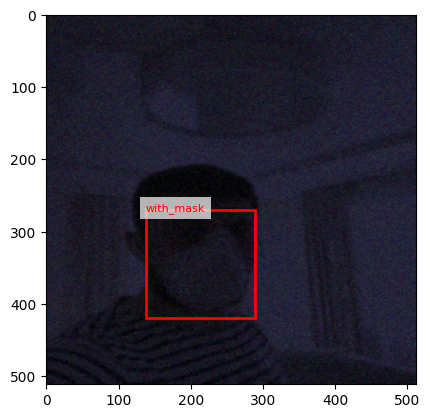

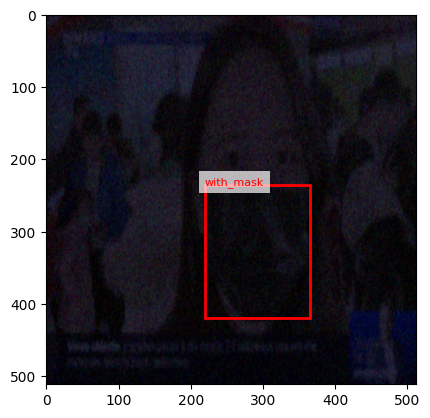

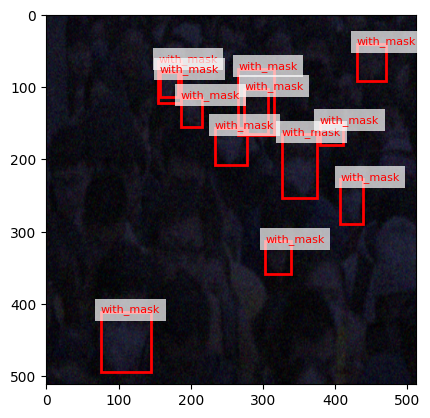

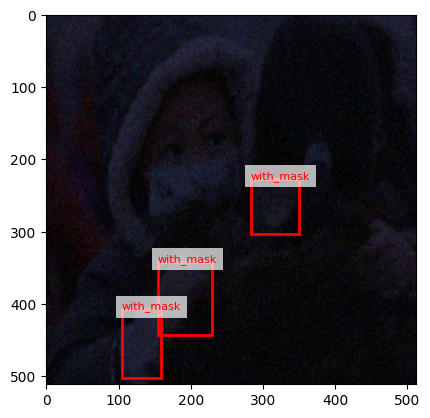

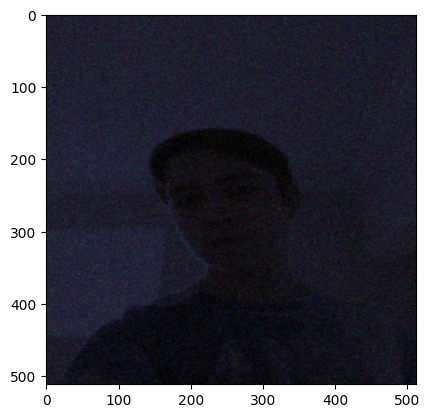

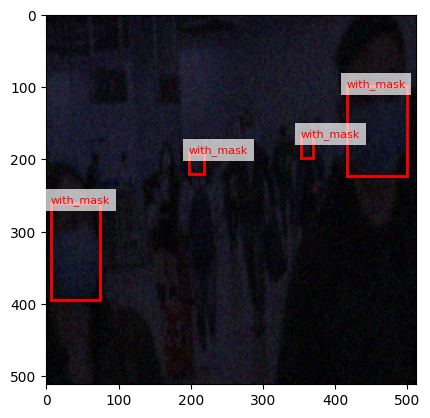

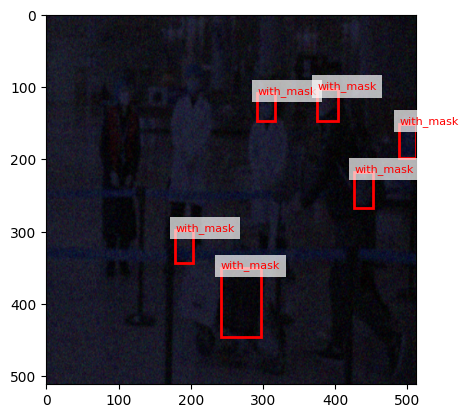

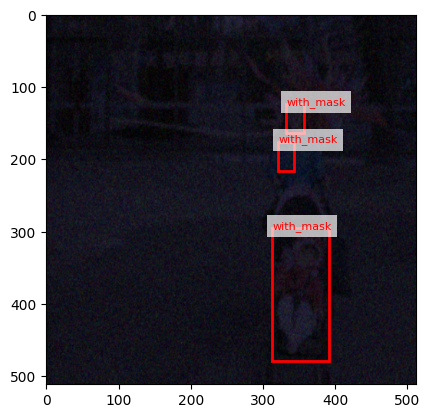

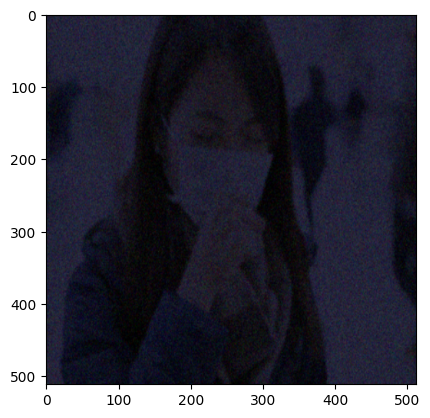

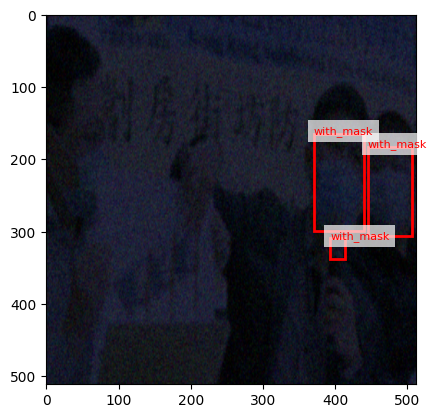

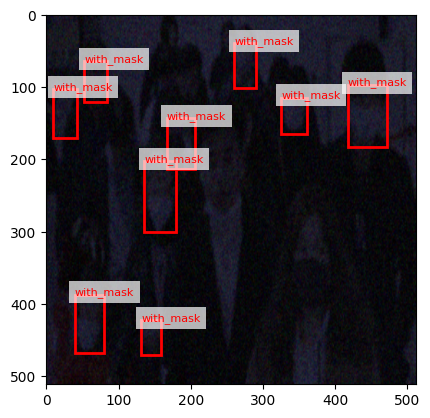

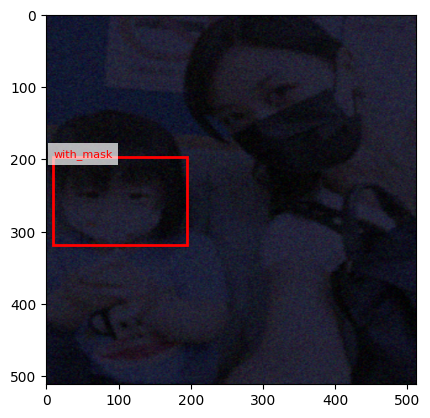

In [39]:
%matplotlib inline

visualize_prediction(sample[0], tmp_model, 0.7, CLASS_LABELS_XML, allowed_labels=[0,1,2])

In [ ]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Example data
ap_values = np.array([[0.1336604111307326, 0.2572986443597569, 0.12526274482158273, 0.03815604297174956, 0.10857036805561665, 0.18126337112288787]])
ar_values = np.array([[0.16886791545790467, 0.23235426241087484, 0.2324068939898222, 0.07379924587970565, 0.20357496961745036, 0.2939869688755546]])
losses = np.array([3.5037081241607666, 3.6299855709075928, 3.4622976779937744, 3.7200026512145996, 3.6070504188537598, 3.6994848251342773, 3.3248205184936523, 3.5635805130004883, 3.1481873989105225, 3.1537773609161377, 3.1776487827301025, 3.0267350673675537, 2.6851000785827637, 2.341665267944336, 2.3802669048309326, 2.3679280281066895, 2.1809561252593994, 1.649352788925171, 1.4990795850753784, 1.6779813766479492, 1.4140602350234985, 1.231289267539978, 1.416856050491333, 1.0606456995010376, 1.271419644355774, 1.4510023593902588, 1.2579773664474487, 1.2900375127792358, 1.2833715677261353, 1.5435937643051147, 1.5499656200408936, 1.7342897653579712, 1.209354281425476, 1.7363111972808838, 1.4293427467346191, 1.236543893814087, 1.341099500656128, 1.3810378313064575, 1.5645396709442139, 1.3667709827423096, 1.321861743927002, 1.231691837310791, 1.4493379592895508, 1.2087459564208984, 1.2802202701568604, 0.9495764970779419, 1.3625209331512451, 1.4193850755691528, 1.267175555229187, 1.0499402284622192, 1.4278004169464111, 1.3183410167694092, 1.1290475130081177, 1.2715775966644287, 1.461753010749817, 1.2128612995147705, 1.2055106163024902, 1.6528123617172241, 1.439558506011963, 1.4825646877288818, 1.5014498233795166, 1.0728124380111694, 1.0361117124557495, 1.2733252048492432, 1.4337694644927979, 1.1425347328186035, 1.1230850219726562, 1.5723543167114258, 1.3280891180038452, 1.228960633277893, 1.6169536113739014, 1.4106683731079102, 1.2980952262878418, 1.2719392776489258, 1.0983800888061523, 1.333081841468811, 1.405930757522583, 1.396582007408142, 1.311752200126648, 1.385640025138855, 1.1991409063339233, 1.13608980178833, 1.3584513664245605, 1.4384853839874268, 1.2216626405715942, 1.176802158355713, 1.3954983949661255, 1.4966717958450317, 1.0391706228256226, 1.0887377262115479, 1.0088064670562744, 1.3441663980484009, 1.3704664707183838, 1.2151366472244263, 1.1837916374206543, 1.3454633951187134, 0.9060193300247192, 1.1234256029129028, 0.9735511541366577, 1.2765697240829468, 0.9969897866249084, 1.0528099536895752, 1.2681838274002075, 1.2032815217971802, 1.2220314741134644, 1.232980489730835, 1.0314080715179443, 0.9789755940437317, 1.0344496965408325, 1.2396109104156494, 0.9542535543441772, 1.0268471240997314, 1.1717567443847656, 1.1754590272903442, 1.038224458694458, 0.9272365570068359, 1.2140474319458008, 1.2733980417251587, 1.1464898586273193, 1.3107318878173828, 1.3790298700332642, 1.0744510889053345, 0.9516040086746216, 0.9471985101699829, 0.9259024858474731, 0.9761648178100586, 0.9030482172966003, 1.1159441471099854, 1.2148674726486206, 0.8116726279258728, 0.9993666410446167, 1.2044483423233032, 1.0967098474502563, 1.099840760231018, 0.8263029456138611, 0.9132804274559021, 1.1015005111694336, 0.9994745254516602, 0.9886894822120667, 1.0296374559402466, 0.8360440135002136, 1.2290242910385132, 0.9658516645431519, 1.0605965852737427, 0.9309883117675781, 0.9531590938568115, 1.0938971042633057, 0.9697134494781494, 1.0931012630462646, 0.7555080056190491, 0.9795594215393066, 1.1657205820083618, 1.1514183282852173, 1.1015238761901855, 0.9521333575248718, 0.8784592747688293, 0.7049698233604431, 1.0020480155944824, 0.8912876844406128, 1.0752222537994385, 0.8315436244010925, 0.9264834523200989, 0.9617635607719421, 1.1116893291473389, 0.869286298751831, 0.848275899887085, 1.083960771560669, 0.8191624283790588, 0.7726817727088928, 1.1378777027130127, 0.9544782638549805, 1.23576021194458, 0.8876957297325134, 0.8360306024551392, 1.1183782815933228, 0.9772667288780212, 0.911658525466919, 0.9340307116508484, 0.8145692348480225, 0.7342631220817566, 1.0272412300109863, 1.084961175918579, 0.9214168787002563, 1.1718870401382446, 0.9201458692550659, 1.1017966270446777, 1.0175362825393677, 0.9210155606269836, 0.6445879340171814, 1.2137960195541382, 1.0920106172561646, 1.133089542388916, 1.1782892942428589, 0.8420720100402832, 1.1289467811584473, 1.0615034103393555, 1.0631905794143677, 1.047206997871399, 0.8898377418518066, 0.8384531736373901, 0.7604085206985474, 0.9913699626922607, 0.8925290107727051, 0.9504936933517456, 1.1399126052856445, 0.9041227102279663, 0.9104090332984924, 1.1615211963653564, 0.8971927165985107, 0.8907128572463989, 1.0931179523468018, 0.9943302869796753, 0.8388250470161438, 0.7271350026130676, 0.6980500817298889, 1.0406149625778198, 0.9293732643127441, 1.1530864238739014, 1.1026678085327148, 0.8523820042610168, 0.8250906467437744, 0.8407036066055298, 1.0905718803405762, 0.671928346157074, 0.9461249709129333, 1.0252585411071777, 0.8156813383102417, 0.8894202709197998, 0.9443094730377197, 0.9729337692260742, 0.9490742087364197, 1.1350271701812744, 0.7949040532112122, 0.9249626398086548, 1.2108118534088135, 1.1002421379089355, 0.9037120342254639, 0.8703814148902893, 1.2403441667556763, 0.8970953822135925, 1.0121947526931763, 0.9674692749977112, 0.9327728748321533, 0.7443950176239014, 0.9559417963027954, 0.8948149085044861, 0.9058948755264282, 1.0102293491363525, 0.8731740117073059, 0.7275518774986267, 0.9054285287857056, 0.799403190612793, 1.0462944507598877, 1.0855087041854858, 0.9002638459205627, 1.1035290956497192, 0.7177465558052063, 0.9062972068786621, 1.0024136304855347, 0.7843819856643677, 0.9408096075057983, 0.7618253827095032, 0.9526293873786926, 0.7875425815582275, 0.7675339579582214, 0.9411113858222961, 0.8316630721092224, 0.9361674785614014, 1.049639105796814, 1.1532046794891357, 0.8380647301673889, 0.8464378714561462, 1.0022947788238525, 0.9521863460540771, 1.1270699501037598, 0.835868775844574, 0.9873954653739929, 0.9738771319389343, 1.0944690704345703, 0.7871044874191284, 0.8491039872169495, 0.5856783986091614, 0.9659832715988159, 0.8312413692474365, 0.7909420728683472, 1.0328478813171387, 0.8515373468399048, 0.9310528039932251, 0.9148926734924316])

ap_values = [  # List of lists representing AP values for each model and metric
    [0.1336604111307326, 0.2572986443597569, 0.12526274482158273, 0.03815604297174956, 0.10857036805561665, 0.18126337112288787],
    [0.225, 0.352, 0.275, 0.095, 0.208, 0.305],
    [0.143, 0.267, 0.158, 0.048, 0.115, 0.196],
    [0.187, 0.302, 0.192, 0.068, 0.145, 0.235]
]

ar_values = [  # List of lists representing AR values for each model and metric
    [0.16886791545790467, 0.23235426241087484, 0.2324068939898222, 0.07379924587970565, 0.20357496961745036, 0.2939869688755546],
    [0.205, 0.275, 0.285, 0.115, 0.235, 0.335],
    [0.175, 0.245, 0.258, 0.098, 0.218, 0.302],
    [0.193, 0.265, 0.278, 0.105, 0.225, 0.318]
]

# Create subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=['0.50:0.95', '0.50', '0.75', '0.50:0.95_small'])

# Add AP plots
for i, values in enumerate(ap_values):
    row = i // 2 + 1
    col = i % 2 + 1
    fig.add_trace(go.Scatter(x=np.arange(len(values)), y=values, mode='lines', name=f'Model {i+1}'), row=row, col=col)

fig.update_xaxes(title_text='Epoch', row=1, col=1)
fig.update_xaxes(title_text='Epoch', row=1, col=2)
fig.update_yaxes(title_text='AP Value', row=1, col=1)
fig.update_yaxes(title_text='AP Value', row=2, col=1)

# Add AR plots
for i, values in enumerate(ar_values):
    row = i // 2 + 1
    col = i % 2 + 3
    fig.add_trace(go.Scatter(x=np.arange(len(values)), y=values, mode='lines', name=f'Model {i+1}'), row=row, col=col)

fig.update_xaxes(title_text='Epoch', row=1, col=3)
fig.update_xaxes(title_text='Epoch', row=1, col=4)
fig.update_yaxes(title_text='AR Value', row=1, col=3)
fig.update_yaxes(title_text='AR Value', row=2, col=3)

fig.update_layout(height=600, width=800, showlegend=False)

fig.show()


In [ ]:
# #load models from disk
# trained_models = {}

# for model_name, model_dict in models_classComparison.items():
#     trained_models[model_name] = {}
#     for model_type, model in model_dict.items():
#         model_filename = f"{model_name}_{model_type}.pth"
#         model_path = os.path.join("finished_models/class_compare/", model_filename)
#         model.load_state_dict(torch.load(model_path))
#         model.eval()
#         trained_models[model_name][model_type] = model

In [24]:
from matplotlib import patches


def visualize_prediction(images, model, confidence_threshold,class_map, allowed_labels = [3, 4, 5, 6],):
    # Set the model to evaluation mode
    model.eval()
    mean=[0.485, 0.456, 0.406] 
    std=[0.229, 0.224, 0.225]
    # Preprocess the images
    ims = list(image.to(device) for image in images)
    # Perform inference
    with torch.no_grad():
        predictions = model(ims)
        #good = torch.argwhere(scores > confidence_threshold)
        #print(predictions)

    for image, prediction in zip(images, predictions):
        # Convert the image tensor to a PIL Image
        #image_pil = transforms.ToPILImage()(image)

        # Unnormalize the image
        image_pil = transforms.ToPILImage()(image)


        # Get the predicted bounding boxes, labels, and scores
        boxes = prediction['boxes'].cpu().numpy()
        labels = prediction['labels'].cpu().numpy()
        scores = prediction['scores'].cpu().numpy()

        # Visualize the image and predicted bounding boxes
        fig, ax = plt.subplots(1)
        ax.imshow(image_pil)

        for box, label, score in zip(boxes, labels, scores):
            if label in allowed_labels and score > confidence_threshold:
                x_min, y_min, x_max, y_max = box
                width = x_max - x_min
                height = y_max - y_min
                class_name = list(class_map.keys())[list(class_map.values()).index(label)]
                rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(x_min, y_min, f"{class_name}", color='r', fontsize=8, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

        plt.show()
    model.train()

In [28]:
iterator = iter(dataloaders["dataset_big_face_classes"]["test"])

In [29]:
sample = next(iterator)

datasets["dataset_big_face_classes"].annotations[0]

([{'isProtected': False,
   'ID': 924868908868875136,
   'BoundingBox': [451, 186, 895, 697],
   'classname': 'face_no_mask',
   'Confidence': 1,
   'Attributes': {}}],
 '1801.jpg')

In [30]:
datasets["dataset_big_all_classes"].__getitem__(0)

(tensor([[[0.5961, 0.5961, 0.5961,  ..., 0.6235, 0.6275, 0.6314],
          [0.5961, 0.5961, 0.6000,  ..., 0.6275, 0.6275, 0.6275],
          [0.5961, 0.5961, 0.5961,  ..., 0.6314, 0.6275, 0.6275],
          ...,
          [0.2784, 0.2784, 0.2745,  ..., 0.5137, 0.5137, 0.5059],
          [0.2784, 0.2784, 0.2745,  ..., 0.5137, 0.5098, 0.5020],
          [0.2784, 0.2745, 0.2745,  ..., 0.5098, 0.5098, 0.5059]],
 
         [[0.5725, 0.5725, 0.5725,  ..., 0.6078, 0.6118, 0.6078],
          [0.5725, 0.5725, 0.5765,  ..., 0.6078, 0.6118, 0.6118],
          [0.5725, 0.5725, 0.5725,  ..., 0.6078, 0.6078, 0.6118],
          ...,
          [0.2627, 0.2627, 0.2588,  ..., 0.4784, 0.4784, 0.4784],
          [0.2627, 0.2627, 0.2588,  ..., 0.4784, 0.4745, 0.4745],
          [0.2627, 0.2588, 0.2588,  ..., 0.4745, 0.4745, 0.4745]],
 
         [[0.5804, 0.5804, 0.5804,  ..., 0.6118, 0.6157, 0.6157],
          [0.5804, 0.5804, 0.5843,  ..., 0.6157, 0.6157, 0.6157],
          [0.5804, 0.5804, 0.5804,  ...,

In [31]:
#how many annotations of the dataset have class label 0 ("face_no_mask")

face_no_mask_count = 0

for item in datasets["dataset_big_face_classes"].annotations:
    objects, _ = item
    for obj in objects:
        if obj['classname'] == 'face_no_mask':
            face_no_mask_count += 1

print(face_no_mask_count)


1569


In [32]:

tmp_model = models_trained["resnet"]["face_classes"]

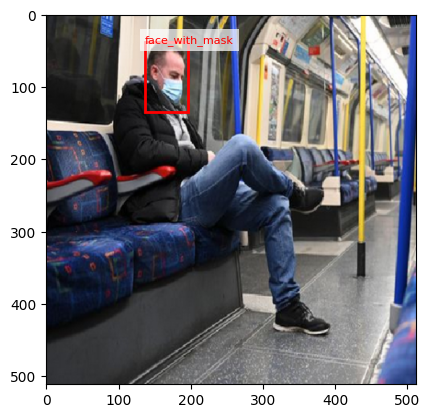

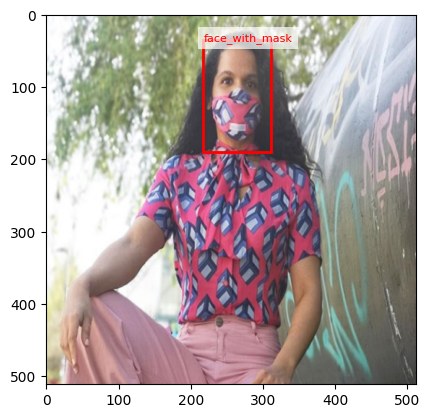

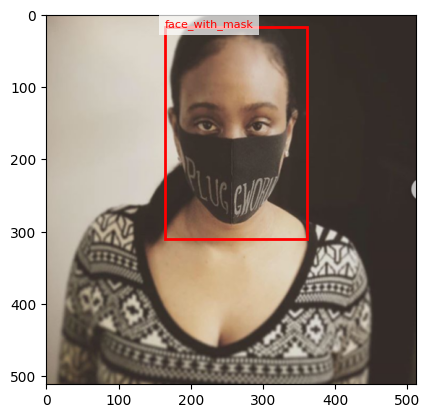

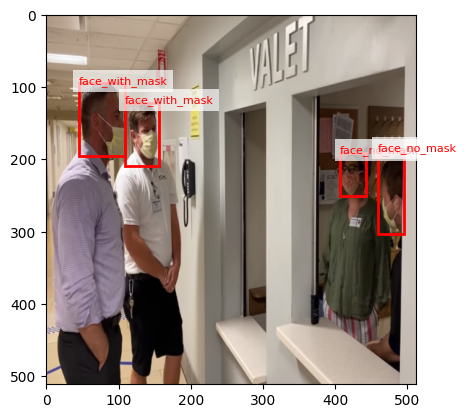

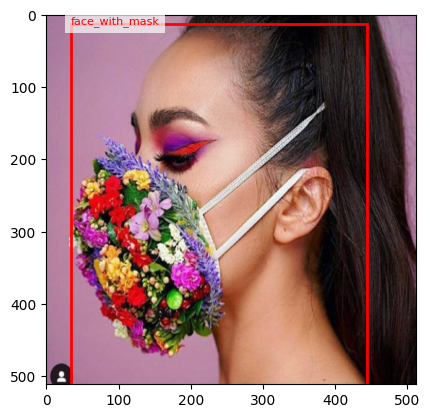

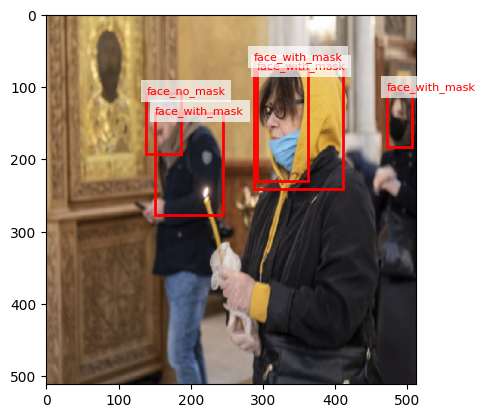

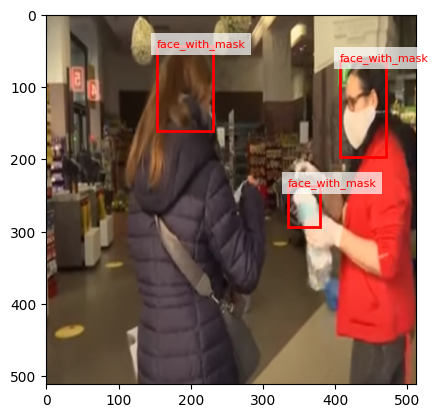

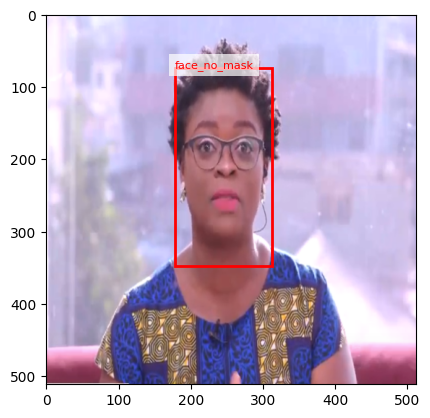

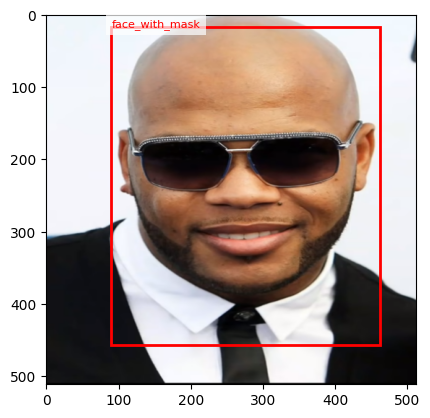

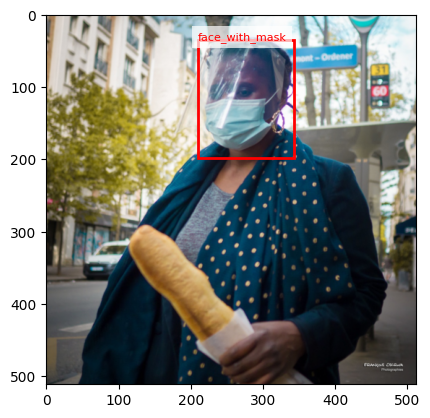

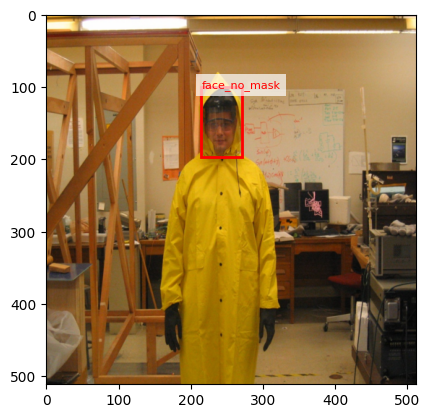

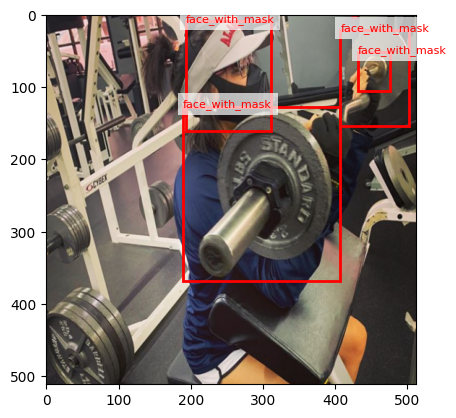

In [33]:
%matplotlib inline

visualize_prediction(sample[0], tmp_model, 0.5, CLASS_LABELS_FACES, allowed_labels=[0,1,2,3])

In [ ]:
face_no_mask_count = 0
face_with_mask_count = 0
face_with_mask_incorrect_count = 0
face_other_covering_count = 0

for images, _ in dataloaders["dataset_big_face_classes"]["test"]:
    tmp_model.eval()
    # Preprocess the images
    ims = [image.to(device) for image in images]

    # Perform inference
    with torch.no_grad():
        predictions = tmp_model(ims)

    for prediction in predictions:
        # Get the predicted labels and scores
        labels = prediction['labels'].cpu().numpy()
        scores = prediction['scores'].cpu().numpy()

        # Filter predictions above the confidence threshold
        filtered_labels = labels[scores > 0.2]

        # Count the number of predictions for each label
        face_no_mask_count += np.count_nonzero(filtered_labels == 0)
        face_with_mask_count += np.count_nonzero(filtered_labels == 2)
        face_with_mask_incorrect_count += np.count_nonzero(filtered_labels == 1)
        face_other_covering_count += np.count_nonzero(filtered_labels == 3)

print("face_no_mask_count:", face_no_mask_count)
print("face_with_mask_count:", face_with_mask_count)
print("face_with_mask_incorrect_count:", face_with_mask_incorrect_count)
print("face_other_covering_count:", face_other_covering_count)
